# Data Science com Python

### Módulo 5 - Modelagem Regressão

***Professor: Lucas Roberto Correa***

LEMBRETE: Fazer o import dos datasets usados no ambiente do colab antes de executar os comandos.

### Import dos pacotes

In [65]:
# Manipulação dados
import pandas as pd

# Visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt

# Quebrar os dados
from sklearn.model_selection import train_test_split

# Feature selection
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

# Modelos de regressão
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Validação cruzada
from sklearn.model_selection import cross_val_score

# Metricas
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.metrics import make_scorer

# Tuning de hiperparametros
from sklearn.model_selection import GridSearchCV

In [66]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

#### Import dos metadados

link da base: https://www.kaggle.com/rashmiranu/banking-dataset-classification?select=new_train.csv

In [67]:
meta = pd.read_excel('metadata.xlsx')

In [68]:
meta

,Feature,Feature_Type,Description
0,age,numeric,age of a person
1,job,"Categorical,nominal","type of job ('admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')"
2,marital,"categorical,nominal","marital status ('divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)"
3,education,"categorical,nominal","('basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')"
4,default,"categorical,nominal","has credit in default? ('no','yes','unknown')"
5,housing,"categorical,nominal","has housing loan? ('no','yes','unknown')"
6,loan,"categorical,nominal","has personal loan? ('no','yes','unknown')"
7,contact,"categorical,nominal","contact communication type ('cellular','telephone')"
8,month,"categorical,ordinal","last contact month of year ('jan', 'feb', 'mar', …, 'nov', 'dec')"
9,dayofweek,"categorical,ordinal","last contact day of the week ('mon','tue','wed','thu','fri')"


#### Import da base

In [69]:
df = pd.read_csv('new_train.csv', sep=',')

In [70]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,no


#### Feature engineering - Criando novas variáveis

In [71]:
df.corr()

,age,duration,campaign,pdays,previous
age,1.000000,-0.001841,0.003302,-0.032011,0.020670
duration,-0.001841,1.000000,-0.075663,-0.047127,0.022538
campaign,0.003302,-0.075663,1.000000,0.053795,-0.079051
pdays,-0.032011,-0.047127,0.053795,1.000000,-0.589601
previous,0.020670,0.022538,-0.079051,-0.589601,1.000000


In [72]:
df['poutcome'].value_counts()

nonexistent    28416
failure         3429
success         1105
Name: poutcome, dtype: int64

In [73]:
df['previous'].value_counts()

0    28416
1     3673
2      606
3      175
4       60
5       14
6        5
7        1
Name: previous, dtype: int64

Criando uma nova variável que traz a escala de dificuldade de contato, baseando-se em poutcome e previous

In [74]:
df['difficulty'] = -1 # para desconhecido 
df.loc[(df['poutcome'] == 'success') & (df['previous'].between(0,1)), 'difficulty'] = 0 # para facil
df.loc[(df['poutcome'] == 'success') & (df['previous'].between(2,4)), 'difficulty'] = 1 # para medio
df.loc[(df['poutcome'] == 'success') & (df['previous'].between(5,7)), 'difficulty'] = 2 # para dificil
df.loc[(df['poutcome'] == 'nonexistent') & (df['previous'] > 7), 'difficulty'] = 2 # para muito dificil
df.loc[(df['poutcome'] == 'failure'), 'difficulty'] = 2 # para impossivel

In [75]:
df['difficulty'].value_counts()

-1    28416
 2     3446
 0      697
 1      391
Name: difficulty, dtype: int64

#### ABT

In [76]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'difficulty'],
      dtype='object')

In [77]:
df.isnull().sum()

age            0
job            0
marital        0
education      0
default        0
housing        0
loan           0
contact        0
month          0
day_of_week    0
duration       0
campaign       0
pdays          0
previous       0
poutcome       0
y              0
difficulty     0
dtype: int64

In [78]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'difficulty'],
      dtype='object')

In [79]:
df.dtypes

age             int64
job            object
marital        object
education      object
default        object
housing        object
loan           object
contact        object
month          object
day_of_week    object
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome       object
y              object
difficulty      int64
dtype: object

Separando as variáveis explicativas da variável resposta

In [80]:
explicativas = df.drop(columns=['age'])

In [81]:
var_resp = df['age']

In [82]:
var_resp.head()

0    49
1    37
2    78
3    36
4    59
Name: age, dtype: int64

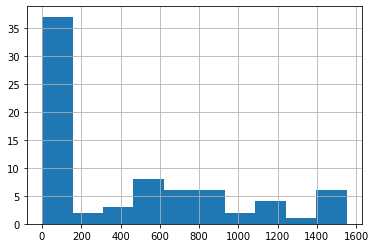

In [83]:
var_resp.value_counts().hist()

In [84]:
explicativas.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y,difficulty
0,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent,no,-1
1,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure,no,2
2,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,yes,-1
3,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,no,-1
4,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,no,-1


Tratamento de enconding das variáveis categóricas

In [85]:
expl_cat = explicativas[['job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month','poutcome','difficulty']]

In [86]:
expl_num = explicativas[['duration', 'campaign', 'pdays', 'previous']]

In [87]:
expl_cat_encoding = pd.get_dummies(expl_cat, prefix_sep='_', columns=expl_cat.columns, 
                                   drop_first=True)

In [88]:
expl_cat_encoding.head()

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_nonexistent,poutcome_success,difficulty_0,difficulty_1,difficulty_2
0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [89]:
explicativas_tratada = expl_num.merge(expl_cat_encoding, left_index=True, right_index=True)

In [90]:
explicativas_tratada.shape

(32950, 46)

Resultado a ser considerado na modelagem

In [91]:
explicativas_tratada.head()

,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_nonexistent,poutcome_success,difficulty_0,difficulty_1,difficulty_2
0,227,4,999,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
1,202,2,999,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,1148,1,999,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,120,2,999,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,368,2,999,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


#### Feature selection

Seleção de variáveis usando DecisionTreeRegressor para variáveis categóricas

In [92]:
dt = DecisionTreeRegressor(random_state=42)

tree_selector = SelectFromModel(dt, max_features=5)
tree_selector.fit(expl_cat_encoding, var_resp)
tree_support = tree_selector.get_support()
tree_feature = expl_cat_encoding.loc[:, tree_support].columns.tolist()
tree_feature

['job_retired', 'marital_single', 'default_unknown', 'housing_yes', 'loan_yes']

Seleção de variáveis usando RandomForestRegressor  para vars numéricas

In [93]:
rfe_selector = RFE(estimator=RandomForestRegressor(random_state=42),
                   n_features_to_select=5,
                   step=1)

rfe_selector.fit(expl_num, var_resp)
rfe_support = rfe_selector.get_support()
rfe_feature = expl_num.loc[:, rfe_support].columns.tolist()
rfe_feature

['duration', 'campaign', 'pdays', 'previous']

Base a ser considerada pós feature selection

In [94]:
expl_num_feature = expl_num[['duration', 'campaign', 'pdays', 'previous']]

In [95]:
expl_cat_feature = expl_cat_encoding[['job_retired', 'marital_single', 'default_unknown', 'housing_yes', 'loan_yes']]

In [96]:
explicativas_modelagem = expl_num_feature.merge(expl_cat_feature, left_index=True, right_index=True)

In [97]:
explicativas_modelagem.head()

,duration,campaign,pdays,previous,job_retired,marital_single,default_unknown,housing_yes,loan_yes
0,227,4,999,0,0,0,1,0,0
1,202,2,999,1,0,0,0,0,0
2,1148,1,999,0,1,0,0,0,0
3,120,2,999,0,0,0,0,1,0
4,368,2,999,0,1,0,0,0,0


#### Quebra do dataset entre treino e teste

In [98]:
x_treino, x_teste, y_treino, y_teste = train_test_split(explicativas_modelagem,
                                                       var_resp,
                                                       test_size=0.3,
                                                       random_state=42)

#### O algoritmo

In [99]:
tree = DecisionTreeRegressor(random_state=42)

In [100]:
tree

DecisionTreeRegressor(random_state=42)

In [101]:
rf = RandomForestRegressor(n_estimators=400,
                           random_state=42)

In [102]:
rf

RandomForestRegressor(n_estimators=400, random_state=42)

#### cross validation

In [103]:
tree_cross = cross_val_score(estimator=tree,
                             X=x_treino,
                             y=y_treino,
                             cv=3,
                             scoring=make_scorer(mean_absolute_error))

In [104]:
tree_cross

array([9.04407074, 9.05239799, 8.9375735 ])

In [105]:
resultado = cross_val_score(estimator=rf,
                           X=x_treino,
                           y=y_treino,
                           cv=3,
                           scoring=make_scorer(mean_absolute_error))

In [106]:
resultado

array([7.55056409, 7.55194655, 7.59332758])

In [107]:
tree.fit(x_treino, y_treino)

DecisionTreeRegressor(random_state=42)

In [108]:
mean_absolute_error(y_treino, tree.predict(x_treino))

2.530197445929074

In [109]:
rf.fit(x_treino, y_treino)

RandomForestRegressor(n_estimators=400, random_state=42)

In [110]:
mean_absolute_error(y_treino, rf.predict(x_treino))

3.989521284731999

#### Analisando overfitting

In [111]:
mean_absolute_error(y_teste, rf.predict(x_teste))

7.524939169740626

In [112]:
y_teste.head()

20628    28
4344     38
20933    41
4641     38
4638     35
Name: age, dtype: int64

In [113]:
rf.predict(x_teste)

array([42.396     , 43.47320696, 36.41666667, ..., 27.97383929,
       35.92128472, 43.92775   ])

#### Tuning de hiperparametros

In [114]:
# dicionario da random Forest

rf_grid_dc = {
    'n_estimators':[50,100,200],
    'bootstrap':[True,False],
    'random_state':[42]
}

rf_grid_dc

{'bootstrap': [True, False],
 'n_estimators': [50, 100, 200],
 'random_state': [42]}

In [115]:
rf_grid = GridSearchCV(rf,
                      rf_grid_dc,
                      cv=2,
                      scoring=make_scorer(mean_absolute_error))
rf_grid

GridSearchCV(cv=2,
             estimator=RandomForestRegressor(n_estimators=400, random_state=42),
             param_grid={'bootstrap': [True, False],
                         'n_estimators': [50, 100, 200], 'random_state': [42]},
             scoring=make_scorer(mean_absolute_error))

In [116]:
rf_grid.fit(x_treino, y_treino)

GridSearchCV(cv=2,
             estimator=RandomForestRegressor(n_estimators=400, random_state=42),
             param_grid={'bootstrap': [True, False],
                         'n_estimators': [50, 100, 200], 'random_state': [42]},
             scoring=make_scorer(mean_absolute_error))

In [117]:
rf_grid.best_params_

{'bootstrap': False, 'n_estimators': 200, 'random_state': 42}

In [118]:
rf_grid.best_score_

9.142200399167528

Validando a performance em teste

In [119]:
mean_absolute_error(y_teste, rf_grid.predict(x_teste))

8.819379929397304

Fazendo o treinamento com tuning de hiperparametros para outro modelo

In [120]:
gb = GradientBoostingRegressor(n_estimators=200,
                           random_state=42)

In [121]:
#dicionario do GB

gb_grid_dc = {
    'max_depth':[1,3,8],
    'n_estimators':[10,20],
    'random_state':[42]
}

In [122]:
gb_grid = GridSearchCV(gb,
                      gb_grid_dc,
                      scoring=make_scorer(mean_absolute_error),
                      n_jobs=4)
gb_grid

GridSearchCV(estimator=GradientBoostingRegressor(n_estimators=200,
                                                 random_state=42),
             n_jobs=4,
             param_grid={'max_depth': [1, 3, 8], 'n_estimators': [10, 20],
                         'random_state': [42]},
             scoring=make_scorer(mean_absolute_error))

In [123]:
gb_grid.fit(x_treino, y_treino)

GridSearchCV(estimator=GradientBoostingRegressor(n_estimators=200,
                                                 random_state=42),
             n_jobs=4,
             param_grid={'max_depth': [1, 3, 8], 'n_estimators': [10, 20],
                         'random_state': [42]},
             scoring=make_scorer(mean_absolute_error))

In [124]:
gb_grid.best_params_

{'max_depth': 1, 'n_estimators': 10, 'random_state': 42}

Podemos especificar no Tuning qual a métrica que se quer otimizar

In [125]:
gb_grid_r2 = GridSearchCV(gb,
                      gb_grid_dc,
                      cv=2,
                          scoring=make_scorer(r2_score))

In [126]:
gb_grid_r2.fit(x_treino, y_treino)

GridSearchCV(cv=2,
             estimator=GradientBoostingRegressor(n_estimators=200,
                                                 random_state=42),
             param_grid={'max_depth': [1, 3, 8], 'n_estimators': [10, 20],
                         'random_state': [42]},
             scoring=make_scorer(r2_score))

In [127]:
gb_grid_r2.best_score_

0.34321787772907686

#### Métricas

RSME

In [128]:
mean_squared_error(y_teste, gb_grid_r2.predict(x_teste), squared=True)

70.96775109108682